#  Minimum Spanning Tree Problem 
## Multicommodity flow formulation


In [1]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display
import matplotlib.pyplot as plt


In [15]:
class args:
    filename = None
    scale = 50
    figsize = (10,10)
    
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()

In [16]:
args.filename = "network1.gml"
args.figsize = 10,12

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 15 nodes and 105 edges


In [17]:
G.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))

In [18]:
G = nx.convert_node_labels_to_integers(G, first_label=0,label_attribute='old' )

In [19]:
G.nodes(data=True)

NodeDataView({0: {'y': 22, 'x': 18, 'old': 1}, 1: {'y': 24, 'x': 5, 'old': 2}, 2: {'y': 33, 'x': 15, 'old': 3}, 3: {'y': 34, 'x': 16, 'old': 4}, 4: {'y': 37, 'x': 14, 'old': 5}, 5: {'y': 8, 'x': 17, 'old': 6}, 6: {'y': 21, 'x': 1, 'old': 7}, 7: {'y': 38, 'x': 25, 'old': 8}, 8: {'y': 24, 'x': 1, 'old': 9}, 9: {'y': 5, 'x': 1, 'old': 10}, 10: {'y': 45, 'x': 1, 'old': 11}, 11: {'y': 16, 'x': 18, 'old': 12}, 12: {'y': 47, 'x': 19, 'old': 13}, 13: {'y': 11, 'x': 12, 'old': 14}, 14: {'y': 23, 'x': 4, 'old': 15}})

In [20]:
pos = {i:(G.nodes[i]['x'] * args.scale,G.nodes[i]['y'] * args.scale) for i in G.nodes()}

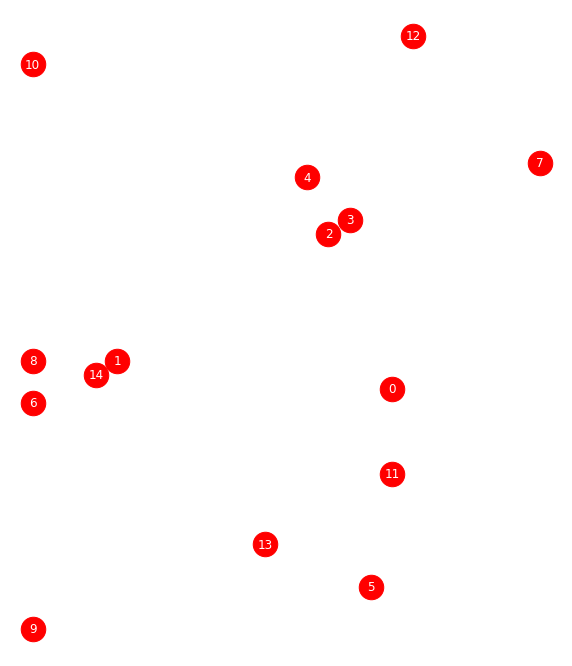

In [21]:
DrawInitG(G)

## Decision variables

$$
x_e = \begin{cases}
1 \text{ if edge $e$ is in the tree} \\
0 \text { otherwise}
\end{cases}
$$

Associate to each edge $e$ two directed arcs $(i,j)$ and $(j,i)$ and let 


$$
y_{ij}= \{\text{capacity for the flow of each commodity $k$ in arc } (i,j)\}
$$

$$
f^k_{ij} = \{\text{flow of commodity $k$ carried by the arc } (i,j)\}
$$


In [22]:
G.nodes()
root = 0

In [23]:
D = G.to_directed()

In [24]:
mstmulti = gb.Model()


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-05-15
Using license file /Users/fabrizio/Solvers/licenses/gurobi.lic


In [25]:
x = mstmulti.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()],\
                    ub = 1.0,\
                    vtype=gb.GRB.BINARY,\
                    name='x')


In [26]:
y = mstmulti.addVars(D.edges(), \
                         ub=1.0, vtype=gb.GRB.BINARY,\
                         name='y')

In [27]:
commodities = list(G.nodes())[1:]
commodities

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [28]:
f = mstmulti.addVars(D.edges(), \
                         commodities, \
                         ub=G.number_of_nodes(), \
                         vtype=gb.GRB.CONTINUOUS, \
                         name='f')

In [29]:
mstmulti.write('multi.lp')

\begin{alignat}{3}
\min cx &&\\
\sum_{j \in \delta^+(0)} f^k_{0j} - \sum_{j \in \delta^-(0)} f^k_{j0} = 1 &&\;\; \forall k \not = \{0\}\\
\sum_{j \in \delta^-(v)} f^k_{jv} - \sum_{j \in \delta^+(v)} f^k_{vj} = 0 &&\;\; \forall k \not = \{0\}, \forall v \in V, v \not = \{0\}, v \not = k \\
\sum_{j \in \delta^-(k)} f^k_{jk} - \sum_{j \in \delta^+(k)} f^k_{kj} = 1 && \;\; \forall k \not = \{0\} \\
f^k_{ij} \le y_{ij} && \;\; \forall (i,j) \text{ and } \forall k \not = \{0\}\\
\sum_{\{i,j\} \in E} (y_{ij} + y_{ji}) = n-1\\
y_{ij} + y_{ji} = x_e && \\
f \ge 0, \; x_e \in \{0,1\}\; 
\forall e \in E, \; \\y_{ij} \in \{0,1\} \; \forall (i,j) \in A
\end{alignat}

In [30]:
# ROOT CONSTRAINTS: there is one constraint for each commodity

for k in commodities:
    name = "Root_Com_"+str(k)
    mstmulti.addConstr(f.sum(root, '*', k) - \
                           f.sum('*',root,k) \
                           == 1, name)

mstmulti.update()

In [31]:
mstmulti.write('multi.lp')

In [32]:
# BALANCE CONSTRAINTS: written for all nodes different from root and for nodes different
# from the terminal of each commodity

for v in commodities:
    for k in commodities:
        if (v != k):
            name = "Balance_"+str(v)+"_Com_"+str(k)
            mstmulti.addConstr(f.sum('*',v,k) - f.sum(v,'*',k) == 0, name)
            

mstmulti.update()


In [33]:
mstmulti.write('multi.lp')

In [34]:
# TERMINAL CONSTRAINTS: there is one constraint for each commodity

for k in commodities:
    name = "Term_Com_"+str(k)
    mstmulti.addConstr(f.sum('*',k,k) - f.sum(k,'*',k) == 1, name)

mstmulti.update()


In [35]:
mstmulti.write('multi.lp')

In [36]:
# VARIABLE CAPACITY constraints

for k in commodities:
    for i,j in D.edges():
        name = "Cap_(%d,%d)" % (i,j) + "_Com_" + str(k)
        mstmulti.addConstr (f [i,j,k] - y[i,j] <= 0, name)

mstmulti.update()


In [37]:
mstmulti.write('multi.lp')

In [38]:
# CARDINALITY constraint

mstmulti.addConstr(y.sum() == G.number_of_nodes() - 1, "Cardinality")

mstmulti.update()

In [39]:
# EQUALITY constraints

for i,j in G.edges():
 
    name = "Equality_x_(%d,%d)"%(i,j)
    mstmulti.addConstr(y[i,j] + y[j,i] -  x[i,j] == 0, name)
    
mstmulti.update()

In [40]:
mstmulti.write('multi.lp')

In [41]:
mstmulti.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3256 rows, 3255 columns and 12285 nonzeros
Model fingerprint: 0x230c275c
Variable types: 2940 continuous, 315 integer (315 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 22805.000000
Presolve removed 0 rows and 105 columns
Presolve time: 0.02s
Presolved: 3256 rows, 3150 columns, 12180 nonzeros
Variable types: 2940 continuous, 210 integer (210 binary)

Root relaxation: objective 1.052000e+04, 1043 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    10520.000000 10520.0000  0.00%     -    0s

Explored 0 nodes (1043 simplex iterat

Optimal solution: 10520.0


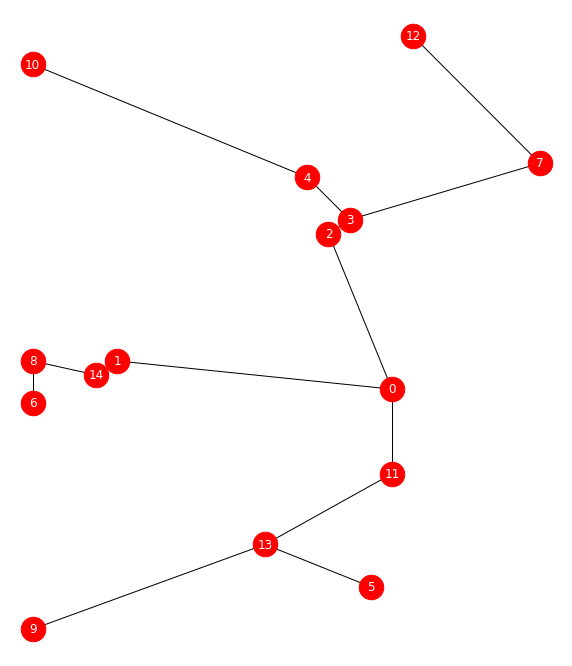

In [42]:
print ("Optimal solution:", mstmulti.objVal)
DrawSol(G,x)


The optimal solution to Ex1. Q1 has value 10520 and the tree is depicted above

In [44]:
G.edges(3)

EdgeDataView([(3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14)])

In [46]:
G.nodes(data=True)

NodeDataView({0: {'y': 22, 'x': 18, 'old': 1}, 1: {'y': 24, 'x': 5, 'old': 2}, 2: {'y': 33, 'x': 15, 'old': 3}, 3: {'y': 34, 'x': 16, 'old': 4}, 4: {'y': 37, 'x': 14, 'old': 5}, 5: {'y': 8, 'x': 17, 'old': 6}, 6: {'y': 21, 'x': 1, 'old': 7}, 7: {'y': 38, 'x': 25, 'old': 8}, 8: {'y': 24, 'x': 1, 'old': 9}, 9: {'y': 5, 'x': 1, 'old': 10}, 10: {'y': 45, 'x': 1, 'old': 11}, 11: {'y': 16, 'x': 18, 'old': 12}, 12: {'y': 47, 'x': 19, 'old': 13}, 13: {'y': 11, 'x': 12, 'old': 14}, 14: {'y': 23, 'x': 4, 'old': 15}})

In [47]:
for i,j in G.edges(2):
    print(G[i][j]['cost'])

1140
1345
141
412
2507
1843
1118
1664
3130
1843
1726
1456
2220
1486


In [48]:
NewG = G.copy()

In [49]:
NewG.edges(data=True)

EdgeDataView([(0, 1, {'cost': 1315}), (0, 2, {'cost': 1140}), (0, 3, {'cost': 1216}), (0, 4, {'cost': 1552}), (0, 5, {'cost': 1403}), (0, 6, {'cost': 1702}), (0, 7, {'cost': 1746}), (0, 8, {'cost': 1711}), (0, 9, {'cost': 2404}), (0, 10, {'cost': 2860}), (0, 11, {'cost': 600}), (0, 12, {'cost': 2501}), (0, 13, {'cost': 1252}), (0, 14, {'cost': 1403}), (1, 2, {'cost': 1345}), (1, 3, {'cost': 1486}), (1, 4, {'cost': 1581}), (1, 5, {'cost': 2000}), (1, 6, {'cost': 500}), (1, 7, {'cost': 2441}), (1, 8, {'cost': 400}), (1, 9, {'cost': 1941}), (1, 10, {'cost': 2137}), (1, 11, {'cost': 1526}), (1, 12, {'cost': 2692}), (1, 13, {'cost': 1476}), (1, 14, {'cost': 141}), (2, 3, {'cost': 141}), (2, 4, {'cost': 412}), (2, 5, {'cost': 2507}), (2, 6, {'cost': 1843}), (2, 7, {'cost': 1118}), (2, 8, {'cost': 1664}), (2, 9, {'cost': 3130}), (2, 10, {'cost': 1843}), (2, 11, {'cost': 1726}), (2, 12, {'cost': 1456}), (2, 13, {'cost': 2220}), (2, 14, {'cost': 1486}), (3, 4, {'cost': 360}), (3, 5, {'cost': 26

In [50]:
for i,j in NewG.edges(2):
    NewG[i][j]['cost'] = NewG[i][j]['cost'] // 10 + 10

In [51]:
NewG.edges(data=True)

EdgeDataView([(0, 1, {'cost': 1315}), (0, 2, {'cost': 124}), (0, 3, {'cost': 1216}), (0, 4, {'cost': 1552}), (0, 5, {'cost': 1403}), (0, 6, {'cost': 1702}), (0, 7, {'cost': 1746}), (0, 8, {'cost': 1711}), (0, 9, {'cost': 2404}), (0, 10, {'cost': 2860}), (0, 11, {'cost': 600}), (0, 12, {'cost': 2501}), (0, 13, {'cost': 1252}), (0, 14, {'cost': 1403}), (1, 2, {'cost': 144}), (1, 3, {'cost': 1486}), (1, 4, {'cost': 1581}), (1, 5, {'cost': 2000}), (1, 6, {'cost': 500}), (1, 7, {'cost': 2441}), (1, 8, {'cost': 400}), (1, 9, {'cost': 1941}), (1, 10, {'cost': 2137}), (1, 11, {'cost': 1526}), (1, 12, {'cost': 2692}), (1, 13, {'cost': 1476}), (1, 14, {'cost': 141}), (2, 3, {'cost': 24}), (2, 4, {'cost': 51}), (2, 5, {'cost': 260}), (2, 6, {'cost': 194}), (2, 7, {'cost': 121}), (2, 8, {'cost': 176}), (2, 9, {'cost': 323}), (2, 10, {'cost': 194}), (2, 11, {'cost': 182}), (2, 12, {'cost': 155}), (2, 13, {'cost': 232}), (2, 14, {'cost': 158}), (3, 4, {'cost': 360}), (3, 5, {'cost': 2601}), (3, 6, {

In [76]:
NewG.nodes()
root = 0

In [77]:
D = NewG.to_directed()

In [78]:
mstmulti = gb.Model()

In [79]:
x = mstmulti.addVars(NewG.edges(), obj=[NewG[u][v]['cost'] for u,v in NewG.edges()],\
                    ub = 1.0,\
                    vtype=gb.GRB.BINARY,\
                    name='x')


In [80]:
y = mstmulti.addVars(D.edges(), \
                         ub=1.0, vtype=gb.GRB.BINARY,\
                         name='y')

In [81]:
commodities = list(NewG.nodes())[1:]
commodities

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [82]:
f = mstmulti.addVars(D.edges(), \
                         commodities, \
                         ub=NewG.number_of_nodes(), \
                         vtype=gb.GRB.CONTINUOUS, \
                         name='f')

In [83]:
mstmulti.write('multi.lp')

\begin{alignat}{3}
\min cx &&\\
\sum_{j \in \delta^+(0)} f^k_{0j} - \sum_{j \in \delta^-(0)} f^k_{j0} = 1 &&\;\; \forall k \not = \{0\}\\
\sum_{j \in \delta^-(v)} f^k_{jv} - \sum_{j \in \delta^+(v)} f^k_{vj} = 0 &&\;\; \forall k \not = \{0\}, \forall v \in V, v \not = \{0\}, v \not = k \\
\sum_{j \in \delta^-(k)} f^k_{jk} - \sum_{j \in \delta^+(k)} f^k_{kj} = 1 && \;\; \forall k \not = \{0\} \\
f^k_{ij} \le y_{ij} && \;\; \forall (i,j) \text{ and } \forall k \not = \{0\}\\
\sum_{\{i,j\} \in E} (y_{ij} + y_{ji}) = n-1\\
y_{ij} + y_{ji} = x_e && \\
f \ge 0, \; x_e \in \{0,1\}\; 
\forall e \in E, \; \\y_{ij} \in \{0,1\} \; \forall (i,j) \in A
\end{alignat}

In [84]:
# ROOT CONSTRAINTS: there is one constraint for each commodity

for k in commodities:
    name = "Root_Com_"+str(k)
    mstmulti.addConstr(f.sum(root, '*', k) - \
                           f.sum('*',root,k) \
                           == 1, name)

mstmulti.update()

In [85]:
mstmulti.write('multi.lp')

In [86]:
# BALANCE CONSTRAINTS: written for all nodes different from root and for nodes different
# from the terminal of each commodity

for v in commodities:
    for k in commodities:
        if (v != k):
            name = "Balance_"+str(v)+"_Com_"+str(k)
            mstmulti.addConstr(f.sum('*',v,k) - f.sum(v,'*',k) == 0, name)
            

mstmulti.update()


In [87]:
mstmulti.write('multi.lp')

In [88]:
# TERMINAL CONSTRAINTS: there is one constraint for each commodity

for k in commodities:
    name = "Term_Com_"+str(k)
    mstmulti.addConstr(f.sum('*',k,k) - f.sum(k,'*',k) == 1, name)

mstmulti.update()


In [89]:
mstmulti.write('multi.lp')

In [90]:
# VARIABLE CAPACITY constraints

for k in commodities:
    for i,j in D.edges():
        name = "Cap_(%d,%d)" % (i,j) + "_Com_" + str(k)
        mstmulti.addConstr (f [i,j,k] - y[i,j] <= 0, name)

mstmulti.update()


In [91]:
mstmulti.write('multi.lp')

In [92]:
# CARDINALITY constraint

mstmulti.addConstr(y.sum() == NewG.number_of_nodes() - 1, "Cardinality")

mstmulti.update()

In [93]:
# EQUALITY constraints

for i,j in NewG.edges():
 
    name = "Equality_x_(%d,%d)"%(i,j)
    mstmulti.addConstr(y[i,j] + y[j,i] -  x[i,j] == 0, name)
    
mstmulti.update()

In [94]:
mstmulti.write('multi.lp')

In [95]:
mstmulti.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3256 rows, 3255 columns and 12285 nonzeros
Model fingerprint: 0x806a0f2a
Variable types: 2940 continuous, 315 integer (315 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 5e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 21789.000000
Presolve removed 0 rows and 105 columns
Presolve time: 0.01s
Presolved: 3256 rows, 3150 columns, 12180 nonzeros
Variable types: 2940 continuous, 210 integer (210 binary)

Root relaxation: objective 2.321000e+03, 270 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2321.0000000 2321.00000  0.00%     -    0s

Explored 0 nodes (270 simplex iteratio

Optimal solution: 2321.0


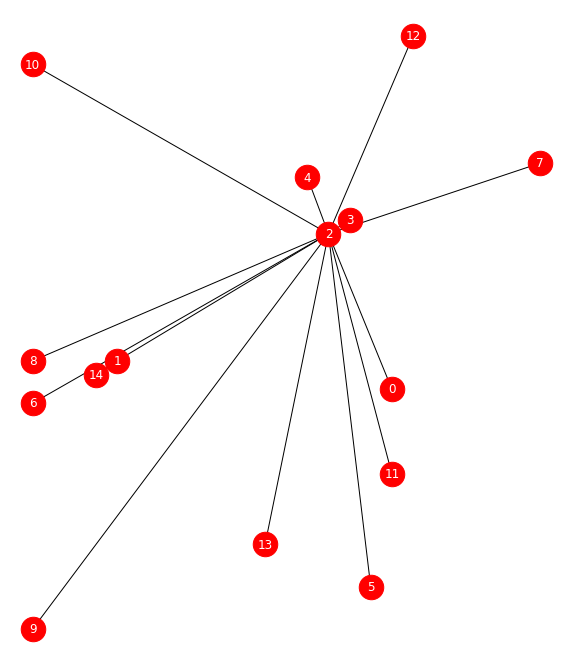

In [96]:
print ("Optimal solution:", mstmulti.objVal)
DrawSol(G,x)


In [97]:
root = 2
rootdeg = 4

mstmulti.addConstr(gb.quicksum([x[u,v] if (u,v) in x else x[v,u] for u,v in NewG.edges(root)]), \
                  sense='<=', rhs=rootdeg, name='RootDegree')




<gurobi.Constr *Awaiting Model Update*>

In [98]:
mstmulti.update()

In [99]:
mstmulti.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3257 rows, 3255 columns and 12299 nonzeros
Model fingerprint: 0x8c00ffbc
Variable types: 2940 continuous, 315 integer (315 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 5e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint RootDegree by 9.000000000

Found heuristic solution: objective 21789.000000
Presolve removed 0 rows and 91 columns
Presolve time: 0.02s
Presolved: 3257 rows, 3164 columns, 12208 nonzeros
Variable types: 2940 continuous, 224 integer (224 binary)

Root relaxation: objective 6.884000e+03, 1017 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

Optimal solution: 6884.0


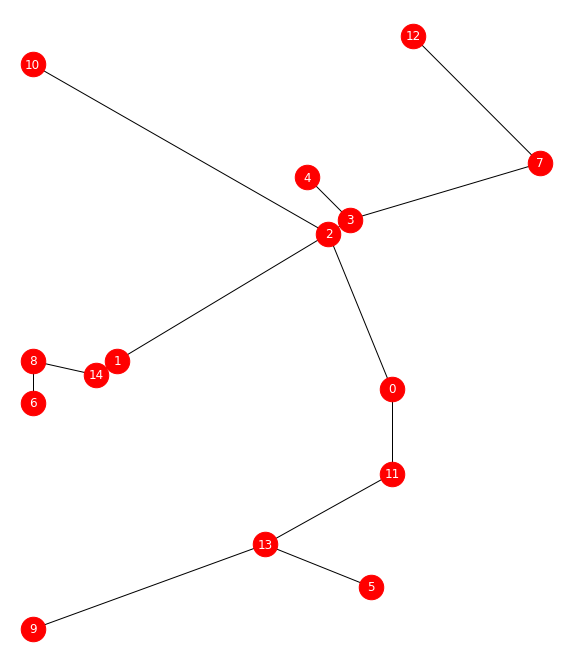

In [100]:
print ("Optimal solution:", mstmulti.objVal)
DrawSol(G,x)



Total cost is 6884 + 100 < 10520. It is convenient to install the hub in node 3 